In [6]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import supervision as sv
from sklearn.metrics import auc
import random
from typing import List, Tuple, Dict, Union

In [7]:
def compute_iou_shapely(box1: List[float], box2: List[float]) -> float:
    # Converting from YOLO format [x_center, y_center, width, height] to shapely format [minx, miny, maxx, maxy]
    x1_center,y1_center,w1,h1=box1
    x2_center,y2_center,w2,h2=box2
    
    # Calculating corners for first box (xmin, ymin, xmax, ymax)
    box1_minx=x1_center-w1/2
    box1_miny=y1_center-h1/2
    box1_maxx=x1_center+w1/2
    box1_maxy=y1_center+h1/2
    
    # Calculating corners for second box (xmin, ymin, xmax, ymax)
    box2_minx=x2_center-w2/2
    box2_miny=y2_center-h2/2
    box2_maxx=x2_center+w2/2
    box2_maxy=y2_center+h2/2
    
    # Creatingb Shapely boxes
    shapely_box1= box(box1_minx,box1_miny,box1_maxx,box1_maxy)
    shapely_box2=box(box2_minx,box2_miny,box2_maxx,box2_maxy)
    
    # Handling invalid boxes (negative area)
    if shapely_box1.area<=0 or shapely_box2.area<=0:
        return 0.0
    
    # Computing intersection and union using Shapely
    intersection=shapely_box1.intersection(shapely_box2).area
    union=shapely_box1.area+shapely_box2.area-intersection
    
    # Computing IoU
    iou=intersection/union if union>0 else 0.0
    
    return iou


In [39]:

def compare_with_supervision(box1: List[float], box2: List[float]) -> Tuple[float, float, float]:
    # Computing IoU using custom function
    our_iou = compute_iou_shapely(box1, box2)
    
    # Convert (cx, cy, w, h) to (x1, y1, x2, y2)
    x1_center, y1_center, w1, h1 = box1
    x2_center, y2_center, w2, h2 = box2
    
    # Convert to absolute coordinates (assuming normalized coordinates in a 100x100 image)
    box1_xyxy = np.array([
        (x1_center - w1 / 2) * 100, (y1_center - h1 / 2) * 100,
        (x1_center + w1 / 2) * 100, (y1_center + h1 / 2) * 100
    ]).reshape(1, 4)

    box2_xyxy = np.array([
        (x2_center - w2 / 2) * 100, (y2_center - h2 / 2) * 100,
        (x2_center + w2 / 2) * 100, (y2_center + h2 / 2) * 100
    ]).reshape(1, 4)

    # Compute IoU using supervision
    supervision_iou = sv.box_iou_batch(box1_xyxy, box2_xyxy)[0, 0]

    # Compute difference
    difference = abs(our_iou - supervision_iou)
    
    return our_iou, supervision_iou, difference


In [10]:
def calculate_precision_recall(gt_boxes: List[List[float]], pred_boxes: List[List[float]], pred_scores: List[float],
                              iou_threshold: float = 0.5) -> Tuple[List[float], List[float], List[int]]:
    """
    Args:
        gt_boxes: List of ground truth boxes in YOLO format [x, y, w, h]
        pred_boxes: List of predicted boxes in YOLO format [x, y, w, h]
        pred_scores: List of confidence scores for predicted boxes
        iou_threshold: IoU threshold for considering a prediction correct
        
    Returns:
        Tuple of (precision_list, recall_list, true_positives)
    """
    # Sorting predictions by confidence score in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    pred_boxes = [pred_boxes[i] for i in sorted_indices]
    pred_scores = [pred_scores[i] for i in sorted_indices]
    
    num_gt = len(gt_boxes)
    num_pred = len(pred_boxes)
    
    # If no ground truth or predictions, return empty lists
    if num_gt == 0 or num_pred == 0:
        return [1.0], [0.0], [0]
    
    # Tracking which ground truth boxes have been matched
    gt_matched=[False]*num_gt
    
    # Lists to store precision and recall values
    true_positives=[0]*num_pred
    false_positives=[0]*num_pred
    
    # For each prediction, finding if it matches a ground truth box
    for pred_idx, pred_box in enumerate(pred_boxes):
        # Finding best matching ground truth box
        best_iou=-1
        best_gt_idx=-1
        
        for gt_idx, gt_box in enumerate(gt_boxes):
            if not gt_matched[gt_idx]:  # Only considering unmatched ground truth boxes
                iou=compute_iou_shapely(pred_box, gt_box)
                if iou>best_iou:
                    best_iou=iou
                    best_gt_idx=gt_idx
        
        # If the best IoU exceeds the threshold, it's a true positive
        if best_iou >= iou_threshold and best_gt_idx!=-1:
            true_positives[pred_idx]=1
            gt_matched[best_gt_idx] = True  # Mark this ground truth as matched
        else:
            false_positives[pred_idx]= 1
    
    # Calculate cumulative values
    cumulative_tp=np.cumsum(true_positives)
    cumulative_fp=np.cumsum(false_positives)
    
    # Calculate precision and recall for each cumulative position
    precision_list=cumulative_tp/(cumulative_tp+cumulative_fp)
    recall_list=cumulative_tp/num_gt if num_gt>0 else np.zeros_like(cumulative_tp)
    
    return precision_list.tolist(), recall_list.tolist(), true_positives

In [11]:
def ap_voc11_point(precision: List[float], recall: List[float]) -> float:
    # Defining 11 equally spaced recall points
    ap = 0.0
    recall_points = np.linspace(0, 1, 11)
    
    # For each recall point, finding the maximum precision at recall >= r
    for r in recall_points:
        max_precision = 0.0
        for i in range(len(precision)):
            if recall[i] >= r:
                max_precision = max(max_precision, precision[i])
        ap += max_precision / 11
    
    return ap


In [13]:
def ap_coco_101_point(precision: List[float], recall: List[float]) -> float:
    #Calculate Average Precision using COCO 101-point interpolation method.
    # Define 101 equally spaced recall points
    ap=0.0
    recall_points=np.linspace(0,1,101)
    
    # For each recall point, find the maximum precision at recall >= r
    for r in recall_points:
        max_precision = 0.0
        for i in range(len(precision)):
            if recall[i]>=r:
                max_precision=max(max_precision,precision[i])
        ap+=max_precision/101
    
    return ap

In [ ]:
def ap_auc(precision: List[float], recall: List[float]) -> float:
    #Calculating Average Precision using area under the precision-recall curve
    #Converting to numpy arrays for processing
    precision=np.array(precision)
    recall=np.array(recall)
    
    # Adding sentinel values to ensure complete curve
    precision=np.concatenate(([1.0], precision, [0.0]))
    recall=np.concatenate(([0.0], recall, [1.0]))
    
    #Ensuring precision is decreasing (for computing the actual AP)
    for i in range(len(precision) - 1, 0, -1):
        precision[i-1] = max(precision[i-1], precision[i])
    
    #Finding points where recall changes
    indices=np.where(recall[1:] != recall[:-1])[0]
    
    #Calculating AUC
    ap=np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    
    return ap


In [16]:
def generate_random_boxes(num_boxes: int, img_size: int, box_size: int) -> List[List[float]]:
    boxes=[]
    half_box_size=box_size/2
    
    for _ in range(num_boxes):
        # Ensuring the box stays within image boundaries
        x_center=random.uniform(half_box_size, img_size-half_box_size)
        y_center=random.uniform(half_box_size, img_size-half_box_size)
        
        # Normalizing coordinates to 0-1 range
        x_center_norm=x_center/img_size
        y_center_norm=y_center/img_size
        width_norm=box_size/img_size
        height_norm=box_size/img_size
        
        boxes.append([x_center_norm, y_center_norm, width_norm, height_norm])
    
    return boxes


In [17]:
def compare_ap_methods(num_images: int = 10) -> Dict[str, float]:
    img_size=100
    box_size=20
    num_gt_per_image=10
    num_pred_per_image=10
    
    all_gt_boxes=[]
    all_pred_boxes=[]
    all_pred_scores=[]
    
    # Generate random data for multiple images
    for i in range(num_images):
        # Generate ground truth boxes
        gt_boxes = generate_random_boxes(num_gt_per_image, img_size, box_size)
        all_gt_boxes.extend(gt_boxes)
        
        # Generate prediction boxes and scores
        pred_boxes = generate_random_boxes(num_pred_per_image, img_size, box_size)
        pred_scores = [random.uniform(0.1, 1.0) for j in range(num_pred_per_image)]
        
        all_pred_boxes.extend(pred_boxes)
        all_pred_scores.extend(pred_scores)
    
    # Calculate precision and recall
    precision, recall, true_positives = calculate_precision_recall(
        all_gt_boxes, all_pred_boxes, all_pred_scores, iou_threshold=0.5
    )
    
    # Calculate AP using different methods
    ap_voc = ap_voc11_point(precision, recall)
    ap_coco = ap_coco_101_point(precision, recall)
    ap_area = ap_auc(precision, recall)
    
    # Plot precision-recall curve
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, 'b-', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve\nVOC AP: {ap_voc:.4f}, COCO AP: {ap_coco:.4f}, AUC AP: {ap_area:.4f}')
    plt.grid(True)
    plt.savefig('precision_recall_curve.png')
    
    return {
        "VOC 11-point AP": ap_voc,
        "COCO 101-point AP": ap_coco,
        "Area under PR curve AP": ap_area
    }

In [18]:
# Demo function to showcase the IoU calculation
def demo_iou_calculation():
    print("Demonstrating IoU calculation with Shapely vs. supervision library")
    
    # Test 1: Completely overlapping boxes
    box1 = [0.5, 0.5, 0.2, 0.2]  # Center at (0.5, 0.5), width=0.2, height=0.2
    box2 = [0.5, 0.5, 0.2, 0.2]  # Same box
    our_iou, supervision_iou, diff = compare_with_supervision(box1, box2)
    print(f"Test 1 (Complete overlap): Our IoU = {our_iou:.4f}, Supervision IoU = {supervision_iou:.4f}, Difference = {diff:.6f}")
    
    # Test 2: Partially overlapping boxes
    box1 = [0.5, 0.5, 0.2, 0.2]  # Center at (0.5, 0.5), width=0.2, height=0.2
    box2 = [0.6, 0.6, 0.2, 0.2]  # Center at (0.6, 0.6), width=0.2, height=0.2
    our_iou, supervision_iou, diff = compare_with_supervision(box1, box2)
    print(f"Test 2 (Partial overlap): Our IoU = {our_iou:.4f}, Supervision IoU = {supervision_iou:.4f}, Difference = {diff:.6f}")
    
    # Test 3: No overlap
    box1 = [0.1, 0.1, 0.1, 0.1]  # Center at (0.1, 0.1), width=0.1, height=0.1
    box2 = [0.9, 0.9, 0.1, 0.1]  # Center at (0.9, 0.9), width=0.1, height=0.1
    our_iou, supervision_iou, diff = compare_with_supervision(box1, box2)
    print(f"Test 3 (No overlap): Our IoU = {our_iou:.4f}, Supervision IoU = {supervision_iou:.4f}, Difference = {diff:.6f}")



=== Part 1: IoU Calculation ===
Demonstrating IoU calculation with Shapely vs. supervision library
Test 1 (Complete overlap): Our IoU = 1.0000, Supervision IoU = 1.0000, Difference = 0.000000
Test 2 (Partial overlap): Our IoU = 0.1429, Supervision IoU = 0.1429, Difference = 0.000000
Test 3 (No overlap): Our IoU = 0.0000, Supervision IoU = 0.0000, Difference = 0.000000

=== Part 2: Average Precision Methods ===

AP50 comparison between methods:
VOC 11-point AP: 0.5031
COCO 101-point AP: 0.4802
Area under PR curve AP: 0.4754
1.VOC 11-point interpolation samples precision at 11 recall points (0, 0.1, ..., 1.0)
2.COCO 101-point interpolation samples at 101 recall points (more granular)
3.Area under PR curve calculates the exact area under the precision-recall curve
4.Differences between methods are expected, with AUC typically the most accurate


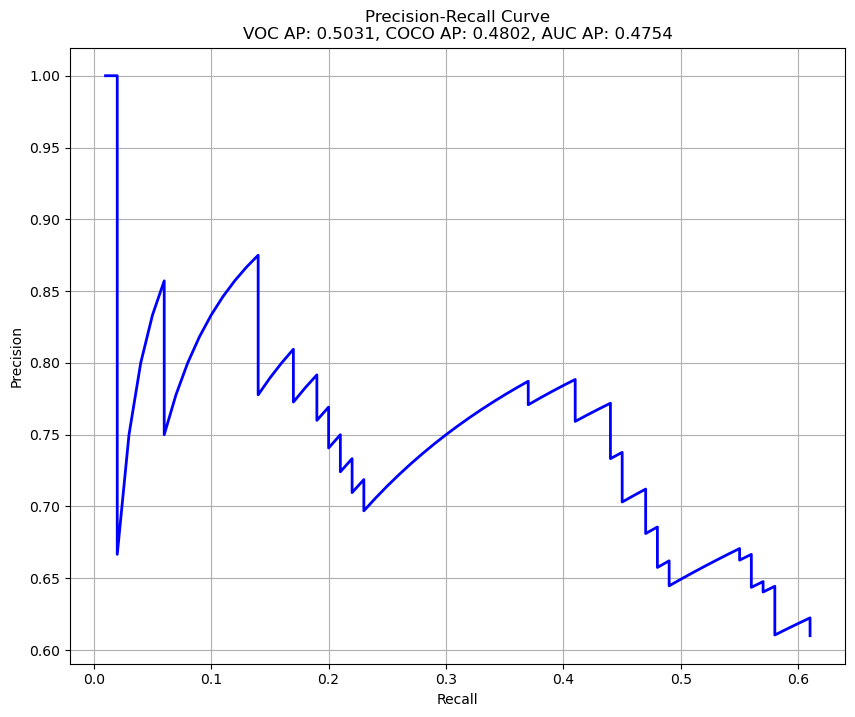

In [41]:
def main():
    # Demo IoU calculation
    print("\n=== Part 1: IoU Calculation ===")
    demo_iou_calculation()
    
    # Demo AP calculation methods
    print("\n=== Part 2: Average Precision Methods ===")
    ap_results = compare_ap_methods(num_images=10)
    
    print("\nAP50 comparison between methods:")
    for method, ap in ap_results.items():
        print(f"{method}: {ap:.4f}")
    
    print("1.VOC 11-point interpolation samples precision at 11 recall points (0, 0.1, ..., 1.0)")
    print("2.COCO 101-point interpolation samples at 101 recall points (more granular)")
    print("3.Area under PR curve calculates the exact area under the precision-recall curve")
    print("4.Differences between methods are expected, with AUC typically the most accurate")

if __name__ == "__main__":
    main()